In [8]:
import numpy as np
import matplotlib.pyplot as plt
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.edmd.edmd import eDMD
from scipy.ndimage import gaussian_filter1d

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 919.33it/s]


ts: (101,)
xhist: (5000, 101, 2)
uhist: (5000, 100, 1)


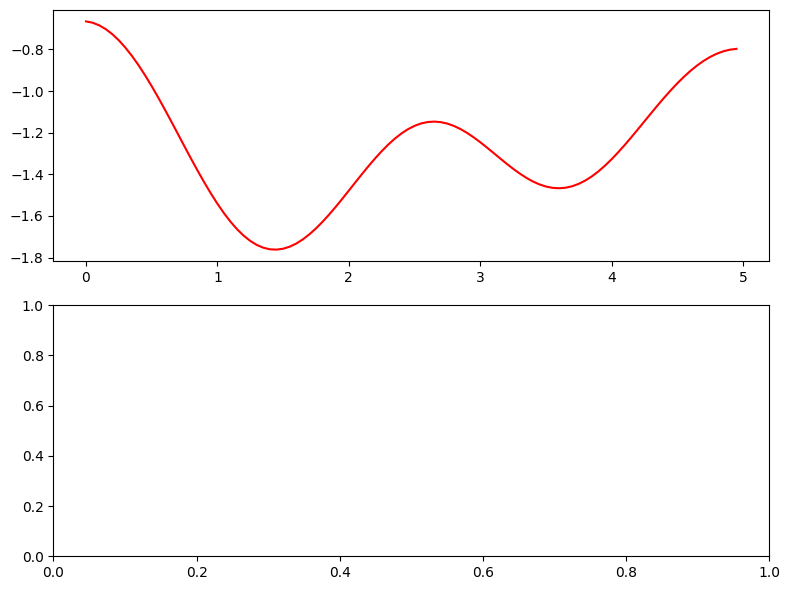

In [26]:
def generate_random_smooth_controls(N, T):
    dt = 0.05
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)
    
    return b_smooth

# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81, b=0.0))

N = 5_000
theta0 = np.random.uniform(-np.pi, np.pi, (N, 1))
omega0 = np.random.uniform(-3.0, 3.0, (N, 1))
x0 = np.hstack((theta0, omega0))
tf = 5.0
dt = 0.05
controls = generate_random_smooth_controls(N, int(tf/dt))
# controls = np.zeros((N, int(tf/dt), 1))

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print("ts:",    ts.shape)
print("xhist:", xhist.shape)
print("uhist:", uhist.shape)

# plot control
# fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# ax[0].plot(ts[:-1], controls[0,:], color='red', label="Control")
# ax[0].plot(eval_ts, eval_xhist_pred[:, 0], color='red', label="Predicted theta", linestyle='--')
# plt.tight_layout()
# plt.show()

In [29]:
def compute_rbf_observables(X, centers, sigma):
    # X: (N_samples, state_dim)
    # centers: (N_rbf, state_dim)
    diffs = X[:, None, :] - centers[None, :, :]  # (N_samples, N_rbf, state_dim)
    sq_dists = np.sum(diffs ** 2, axis=-1)       # (N_samples, N_rbf)
    return np.exp(-sq_dists / (2 * sigma**2))    # (N_samples, N_rbf)

def koopman_observables(xhist: np.ndarray, deg=None) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)

    B, _ = xhist.shape
    centers = np.column_stack([
        np.sin(np.linspace(-np.pi, np.pi, 20)),
        np.cos(np.linspace(-np.pi, np.pi, 20)),
        np.linspace(-3.0, 3.0, 20)
    ])
    X = np.column_stack([
        np.sin(xhist[:, 0]),
        np.cos(xhist[:, 0]),
        xhist[:, 1],
    ])
    
    rbfs = compute_rbf_observables(X, centers, sigma=0.2)
    theta, omega = xhist[:, 0], xhist[:, 1]

    Y = np.column_stack([
        np.sin(theta),
        np.cos(theta),
        np.cos(theta) * omega,
        np.sin(theta) * omega**2,
        np.cos(theta) * np.sin(theta),
    ])
    
    out = np.concatenate([
        xhist, Y
    ], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to pendulum data using degree 4 polynomial observables of sin/cos/omega
edmd = eDMD(1, 2)
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)

print(np.max(zhist))
print(np.min(zhist))
print(np.isnan(zhist).any())
print(np.isinf(zhist).any())

assert np.allclose(zhist[:, 0, :Pendulum.nx], xhist[:, 0, :])

_ = edmd.fit(zhist , uhist)

(505000, 20)
760.5319666841774
-658.4380116453442
False
False
Fitting EDMD model with data:
	zhist.shape=(5000, 101, 7)
	uhist.shape=(5000, 100, 1)
	# of trajectories: 5000
	# of time steps: 101
	# of lifted states: 7
	# of controls: 1
Fitting results:
	self.kpA.shape=(7, 7)
	self.kpB.shape=(7, 1)
	A condition number: 26.36104271065454
	B condition number: 1.0
	Residual: 2.4086829937693723e-06


Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 5440.44it/s]


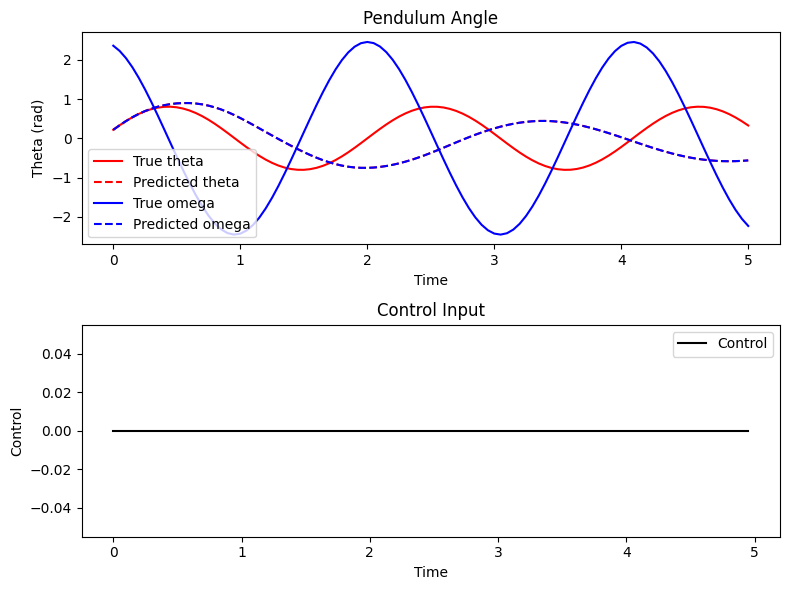

In [16]:
# Evaluate the model on some new data
theta0 = np.random.uniform(-np.pi, np.pi, 1)
omega0 = np.random.uniform(-5.0, 5.0, 1)
x0 = np.concatenate((theta0, omega0))
controls = np.zeros((int(tf/dt), 1)) #np.squeeze(generate_random_smooth_controls(1, int(tf/dt)), axis=0)

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

zjm1 = koopman_observables(x0, deg=2)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj)
    
    zjm1 = zj

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# ax[0].plot(eval_ts, angle_wrap(eval_xhist[:, 0], "-pi:pi"), color='red', label="True theta")
# ax[0].plot(eval_ts, angle_wrap(eval_xhist_pred[:, 0], "-pi:pi"), color='red', label="Predicted theta", linestyle='--')
ax[0].plot(eval_ts, eval_xhist[:, 0], color='red', label="True theta")
ax[0].plot(eval_ts, eval_xhist_pred[:, 0], color='red', label="Predicted theta", linestyle='--')
ax[0].plot(eval_ts, eval_xhist[:, 1], color='blue', label="True omega")
ax[0].plot(eval_ts, eval_xhist_pred[:, 1], color='blue', label="Predicted omega", linestyle='--')
ax[0].set_title("Pendulum Angle")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Theta (rad)")
ax[0].legend()

ax[1].plot(eval_ts[:-1], eval_uhist[:, 0], color='black', label="Control")
ax[1].set_title("Control Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Control")
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
print(
    repr(edmd.kpA)
)

print(
    repr(edmd.kpB)
)

print(
    repr(edmd.kpCs)
)

array([[ 1.00000028e+00,  4.99994091e-02, -1.22625116e-02,
         4.41556269e-08, -2.03048122e-04,  2.54649293e-06,
         2.45549409e-05],
       [ 3.60427626e-05,  9.99924725e-01, -4.90499537e-01,
         2.40270094e-06, -1.20764147e-02,  2.01341265e-04,
         1.94608844e-03],
       [-3.04088901e-04,  6.78266731e-04,  1.00000695e+00,
        -7.60756598e-06,  4.83874219e-02, -1.21740837e-03,
        -1.18808160e-02],
       [ 3.01593235e-05, -9.54253526e-05, -2.02101770e-03,
         9.83030394e-01,  3.45406291e-04,  1.82122386e-04,
         4.06834906e-04],
       [-1.85424268e-02,  4.39893512e-02, -6.22520373e-03,
         2.80651018e-04,  8.98479973e-01, -4.70514895e-02,
        -4.67616771e-01],
       [ 7.43207802e-01, -1.96099956e+00,  6.88010064e-01,
        -7.05683765e-02,  4.23364550e+00,  7.96585629e-01,
        -8.16420928e-02],
       [ 1.43924972e-03, -3.87690617e-03,  1.32482245e-02,
         1.79579886e-04,  1.55743363e-02, -3.97842996e-04,
         9.2351441

In [13]:
print(np.concatenate(edmd.kpCs, axis=0).shape)

TypeError: dispatcher for __array_function__ did not return an iterable